# Import package

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import music21 as m21
from itertools import combinations

In [2]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

# Global variables

In [3]:
FOUR_PART_VOICES = ['S', 'A', 'T', 'B']
OUTTER_VOICES = ['S', 'B']
INNER_VOICES = ['A', 'T']

In [89]:
WRONG_TYPE = {
    'Vocal range': '個別音域',
    'Spacing': '音域配置',
    'Voice crossing': '交越',
    'Overlapping': '越位',
    'Melody interval': '單聲部橫向旋律包含增減音程',
    'Melody_violate_error_jump': '大跳後無反向小跳或級進',
    'Melody_violate_error_direction': '大跳後無反向',
    'Melody_violate_big_jump': '聲部大跳違反原則',
    'Parallel': '平行一五八',
    'Contrary': '反向八五度',
    'Hidden': '隱伏八五度(外聲部)',
    'Harmony': '和聲方面有問題',
    'lecture_unavailable_rn': '實際使用的和弦級數超出單元範圍',
    'multiple_leading_tone': '導音重複',
    'multiple_seventh': '七和弦七音重複',
    'leading_tone_error': '小調導音未升高',
    'leading_tone_resolution': '外聲部導音沒有解決至主音'
}

In [90]:
# (scale_degree, music21.figuredBass.notation.Notation.origNumbers)
L7 = [(1,(None,)), (5,(None,)), (5,(7,))]
L8 = [(1,(6,)), (5,(6,)), (5,(6,5)), (7,(6,))]
L9 = [(5,(4,3)), (5,(4,2))]  # including 43 & 42
L10 = [(2,(None,)), (2,(6,)), (4,(None,))]
#L11 = Cadential 64
L12 = [(4,(6,)), (6,(None,))]
L13 = [(2,(7,)), (4,(7,))]
L14 = [(2,(4,3)), (2,(4,2)), (2,(6,5)), (4,(4,3)), (4,(4,2)), (4,(6,5)), (6,(6,))]
RN_AVAILABLE = {  
    'L7': L7,
    'L8': L7 + L8,
    'L9': L7 + L8 + L9,
    'L10': L7 + L8 + L9 + L10,
    'L11': L7 + L8 + L9 + L10,
    'L12': L7 + L8 + L9 + L10 + L12,
    'L13': L7 + L8 + L9 + L10 + L12 + L13,
    'L14': L7 + L8 + L9 + L10 + L12 + L13 + L14
}

# Functions

### 判斷調性

In [91]:
def detect_key_by_key_sign(key_sign, question_type, VOICES, df, key_student):
    '''從調號推測'''
    possible_key_major = key_sign.asKey()
    possible_key_minor = key_sign.asKey(mode='minor')  # natural form
    possible_key_minor.abstract = m21.scale.AbstractHarmonicMinorScale()  # turn to harmonic scale
    #minor_leading_tone = possible_key_minor.pitchesFromScaleDegrees([7])[0].name  # 導音
    minor_leading_tone = possible_key_minor.getLeadingTone().name
    print(f"possible_key_major: {possible_key_major}")  #, major_leading_tone: {major_leading_tone}")  
    print(f"possible_key_minor: {possible_key_minor}, minor_leading_tone: {minor_leading_tone}")
    
    if pd.notna(question_type):  # 題目有提供高音題 or 低音題
        if question_type=='B':   # 低音題: 因為必結束在一級原位, 直接看最後一個音即可
            ending_note = m21.note.Note(df.iloc[-1,:][question_type]).name
            if ending_note==possible_key_major.tonic:
                key = possible_key_major
            elif ending_note==possible_key_minor.tonic:
                key = possible_key_minor
            else:
                sys.stderr.write(f"something wrong with question_type {question_type} and the ending note {ending_note}")
                # 從寫作內容判斷調性
                key = detect_key_by_ending_chord(df, VOICES, key_sign, minor_leading_tone, key_student,
                                                  possible_key_major, possible_key_minor)

        elif question_type=='S': # 高音題: 不一定在音級1
            ending_note = m21.note.Note(df.iloc[-1,:][question_type]).name
            if ending_note==possible_key_major.pitchFromDegree(5).name:  # 大調 音級5
                key = possible_key_major
            elif ending_note==possible_key_minor.tonic:                  # 小調 音級1
                key = possible_key_minor
            else:                                                         # 大調 音級 1,3 == 小調音級 3,5
                # 看 S 旋律中有沒有導音升高 -> 有: 小調, 沒有: 大調. 預設未知
                key = detect_key_by_melody(None, df, VOICES, minor_leading_tone, possible_key_minor)
                # 從寫作內容判斷調性: 看最後一個和弦
                if not key:
                    key = detect_key_by_ending_chord(df, VOICES, key_sign, minor_leading_tone, key_student,
                                                  possible_key_major, possible_key_minor)
        
        else:  # question_type 讀取異常 (只允許 np.nan, 'S', 'B')
            sys.stderr.write(f"something wrong with question_type {question_type}")
            # 從寫作內容判斷調性: 看最後一個和弦
            key = detect_key_by_ending_chord(df, VOICES, key_sign, minor_leading_tone, key_student,
                                                  possible_key_major, possible_key_minor)
            
    else:  # 題目沒有提供高音題 or 低音題, 從寫作內容判斷調性: 看最後一個和弦
        key = detect_key_by_ending_chord(df, VOICES, key_sign, minor_leading_tone,  key_student,
                                                  possible_key_major, possible_key_minor)
    
    return key

In [92]:
def detect_key_by_melody(key_detected, df, VOICES, minor_leading_tone, possible_key_minor):
    '''看旋律中有沒有導音升高 -> 有: 小調, 沒有: 大調'''
    for n in df[VOICES].to_numpy().flatten():
        if m21.note.Note(n).name == minor_leading_tone:
            key_detected = possible_key_minor
            break
    return key_detected

In [93]:
def detect_key_by_ending_chord(df, VOICES, key_sign, minor_leading_tone, key_student,
                               possible_key_major, possible_key_minor):
    '''從寫作內容判斷調性: 看最後一個和弦'''
    ending_chord = m21.chord.Chord(df[VOICES].iloc[-1,:].values)  # end on tonic
    possible_scale_degree_major = m21.roman.romanNumeralFromChord(ending_chord, possible_key_major).scaleDegree
    possible_scale_degree_minor = m21.roman.romanNumeralFromChord(ending_chord, possible_key_minor).scaleDegree
    if possible_scale_degree_major == 1:
        key_detected = possible_key_major
    elif possible_scale_degree_minor == 1:
        key_detected = possible_key_minor
    else:
        sys.stderr.write(f"something wrong with detecting key by matching key signature {key_sign} and the ending chord {ending_chord}")
        # e.g. C大調 4聲部都停在音級3
        # 看旋律中有沒有導音升高 -> 有: 小調, 沒有: 大調. 預設大調
        key_detected = detect_key_by_melody(possible_key_major, df, VOICES, minor_leading_tone, possible_key_minor)
    
    print("The key should be", key_detected)
        
    if key_student==key_detected:
        print('The student answers a correct key:', key_student)
        key = key_student
    else:
        print(f'The student answers {key_student}, while key detected should be {key_detected}')
        key = key_detected
    
    return key

### 音程

In [94]:
def simple_interval(original_interval):
    '''in music analysis, we distinguish perfect octave (including double-octave,...) from perfect union'''
    if original_interval.simpleName=='P1':
        if original_interval.name=='P1':
            return 'P1'
        else:
            return 'P8'
    else:
        return original_interval.simpleName

## 1. 音域方面

### 個別音域 (Vocal Range)

In [95]:
def vocal_range_detection(VOICES, df):
    ALLOWABLE_EXTENSIONS = {
        'S': {'lower_note': 'B3', 'higher_note': 'A5'},
        'A': {'lower_note': 'G3', 'higher_note': 'D5'},
        'T': {'lower_note': 'C3', 'higher_note': 'A4'},
        'B': {'lower_note': 'D2', 'higher_note': 'D4'}
    }
    
    vocal_range_detector = []
    for v in VOICES:
        lower_note = m21.note.Note(ALLOWABLE_EXTENSIONS[v]['lower_note'])
        higher_note = m21.note.Note(ALLOWABLE_EXTENSIONS[v]['higher_note'])
        for idx,n in enumerate(df[v]):
            current_note = m21.note.Note(n)
            compared_with_lower_note = m21.interval.Interval(noteStart=lower_note, noteEnd=current_note)
            if compared_with_lower_note.direction.value < 0:  # 超過下限
                vocal_range_detector.append(pd.Series({
                    'Voice 1': v,
                    'Voice 2': None,
                    'Place type': 'Vertical',
                    'Place': idx,
                    'Wrong type': 'Vocal range',
                    'Level': 'Wrong',
                    'Remark': f"note {current_note.nameWithOctave} lower than lower bound {lower_note.nameWithOctave}"
                }))

            compared_with_higher_note = m21.interval.Interval(noteStart=current_note, noteEnd=higher_note)
            if compared_with_higher_note.direction.value < 0:  # 超過上限
                vocal_range_detector.append(pd.Series({
                    'Voice 1': v,
                    'Voice 2': None,
                    'Place type': 'Vertical',
                    'Place': idx,
                    'Wrong type': 'Vocal range',
                    'Level': 'Wrong',
                    'Remark': f"note {current_note.nameWithOctave} higher than upper bound {higher_note.nameWithOctave}"
                }))

    if vocal_range_detector:
        return pd.concat(vocal_range_detector, axis=1).T

### 配置 (Spacing)

In [96]:
def spacing_detection(VOICES, df):
    SPACEING = {
        ('S', 'A'): 'P8',
        ('A', 'T'): 'P8',
        ('T', 'B'): 'P12'
    }
    spacing_detector = []
    for v, voice_1 in enumerate(VOICES[:-1]):
        voice_2 = VOICES[v+1]
        allowable_spacing = m21.interval.Interval(SPACEING[(voice_1, voice_2)])
        
        for idx in df.index:
            higher_note = m21.note.Note(df[voice_1][idx])
            lower_note = m21.note.Note(df[voice_2][idx])
            vertical_interval = m21.interval.Interval(noteStart=lower_note, noteEnd=higher_note)
            if m21.interval.subtract([allowable_spacing,vertical_interval]).direction.value < 0:
                spacing_detector.append(pd.Series({
                        'Voice 1': voice_1,
                        'Voice 2': voice_2,
                        'Place type': 'Vertical',
                        'Place': idx,
                        'Wrong type': 'Spacing',
                        'Level': 'Wrong',
                        'Remark': f"{vertical_interval.name} is bigger than allowable spacing {allowable_spacing.name}"
                    }))
    if spacing_detector:
        return pd.concat(spacing_detector, axis=1).T

### 交越 (Voice Crossing)

In [97]:
def voice_crossing_detection(VOICES, df):
    voice_crossing_detector = []
    for v, voice_1 in enumerate(VOICES[:-1]):
        voice_2 = VOICES[v+1]
        for idx in df.index:
            higher_note = m21.note.Note(df[voice_1][idx])
            lower_note = m21.note.Note(df[voice_2][idx])
            vertical_interval = m21.interval.Interval(noteStart=lower_note, noteEnd=higher_note)

            if vertical_interval.direction.value < 0:
                voice_crossing_detector.append(pd.Series({
                        'Voice 1': voice_1,
                        'Voice 2': voice_2,
                        'Place type': 'Vertical',
                        'Place': idx,
                        'Wrong type': 'Voice crossing',
                        'Level': 'Wrong',
                        'Remark': f"{voice_1}: {higher_note.nameWithOctave} is lower than {voice_2}: {lower_note.nameWithOctave}"
                    }))
    if voice_crossing_detector:
        return pd.concat(voice_crossing_detector, axis=1).T

### 越位 (Overlapping)

In [98]:
def overlapping_detection_inner_function(df, voice_1, voice_2): 
    '''voice_1 is upper voice, voice_2 is lower voice'''
    
    overlapping_detector = []

    for i in df.index[:-1]:
            horizontal_interval_voice_1 = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_1][i]),
                                        noteEnd=m21.note.Note(nameWithOctave=df[voice_1][i+1]))
            horizontal_interval_voice_2 = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_2][i]),
                                        noteEnd=m21.note.Note(nameWithOctave=df[voice_2][i+1]))

            # do two voices go same direction?
            if horizontal_interval_voice_1.direction.name==horizontal_interval_voice_2.direction.name:
                if (horizontal_interval_voice_1.direction.value>0) or (horizontal_interval_voice_2.direction>0):    # 上行
                    expected_higher_note = m21.note.Note(df[voice_1][i])
                    expected_lower_note = m21.note.Note(df[voice_2][i+1])
                    interval = m21.interval.Interval(noteStart=expected_lower_note, noteEnd=expected_higher_note)
                    if interval.direction.value < 0:
                        overlapping_detector.append(pd.Series({
                            'Voice 1': voice_1,
                            'Voice 2': voice_2,
                            'Place type': 'Horizontal',
                            'Place': (i, i+1),
                            'Wrong type': 'Overlapping',
                            'Level': 'Wrong',
                            'Remark': f"{voice_2}: {expected_lower_note.nameWithOctave} at {i+1} is higher than {voice_1}: {expected_higher_note.nameWithOctave} at {i}"
                        }))

                elif (horizontal_interval_voice_1.direction.value>0) or (horizontal_interval_voice_2.direction>0):  # 下行
                    expected_higher_note = m21.note.Note(df[voice_1][i+1])
                    expected_lower_note = m21.note.Note(df[voice_2][i])
                    interval = m21.interval.Interval(noteStart=expected_lower_note, noteEnd=expected_higher_note)
                    if interval.direction.value < 0:
                        overlapping_detector.append(pd.Series({
                            'Voice 1': voice_1,
                            'Voice 2': voice_2,
                            'Place type': 'Horizontal',
                            'Place': (i, i+1),
                            'Wrong type': 'Overlapping',
                            'Level': 'Wrong',
                            'Remark': f"{voice_1}: {expected_higher_note.nameWithOctave} at {i+1} is lower than {voice_2}: {expected_lower_note.nameWithOctave} at {i}"
                        }))
                else:  # 有一聲部沒有移動. 如果越位, 必定交越, 所以不用檢查.
                    continue

    if overlapping_detector:
        return pd.concat(overlapping_detector, axis=1).T
    
def overlapping_detection(VOICES, df):
    overlapping_detector = []
    for v, voice_1 in enumerate(VOICES[:-1]):
        voice_2 = VOICES[v+1]
        temp = overlapping_detection_inner_function(df, voice_1, voice_2)
        if type(temp)!=type(None):
            overlapping_detector.append(temp)

    if overlapping_detector:
        return pd.concat(overlapping_detector).reset_index(drop=True)


## 2. 旋律方面

### 單一聲部橫向進行不可有增減音程, A4,d5 除外

In [99]:
def melody_interval_detection(VOICES, df, key, leading_tone):
    melody_interval_detector = []
    
    for v in VOICES:
        for idx in df.index[:-1]:
            level = 'Wrong'
            note_1 = m21.note.Note(nameWithOctave=df[v][idx])
            note_2 = m21.note.Note(nameWithOctave=df[v][idx+1])
            horizontal_interval =  m21.interval.Interval(noteStart=note_1,
                                                         noteEnd=note_2)

            if horizontal_interval.diatonic.specifierAbbreviation == 'A':
                if (abs(horizontal_interval.generic.directed)!=4) \
                  or (abs(horizontal_interval.generic.directed)==4 \
                      and (note_1.name!=leading_tone and note_2.name!=leading_tone)):  #包含導音的A4, d5 可接受
                    if (key.mode=='minor') \
                        and (abs(horizontal_interval.generic.directed)==2) \
                        and (leading_tone==horizontal_interval.noteStart.name \
                             or leading_tone==horizontal_interval.noteEnd.name):  # 小調遇導音增二度
                        level = 'Warning'
                    
                    melody_interval_detector.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Horizontal',
                        'Place': (idx,idx+1),
                        'Wrong type': 'Melody interval',
                        'Level': level,
                        'Remark': f"Interval {horizontal_interval.niceName}",
                        'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval)}"
                    }))

            elif horizontal_interval.diatonic.specifierAbbreviation == 'd':
                if abs(horizontal_interval.generic.directed)!=5 \
                  or (abs(horizontal_interval.generic.directed)==5 \
                    and (note_1.name!=leading_tone and note_2.name!=leading_tone)):
                    melody_interval_detector.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Horizontal',
                        'Place': (idx,idx+1),
                        'Wrong type': 'Melody interval',
                        'Level': level,
                        'Remark': f"Interval {horizontal_interval.niceName}",
                        'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval)}"
                    }))
            
    if melody_interval_detector:
        return pd.concat(melody_interval_detector, axis=1).T

In [185]:
def leading_tone_resolution_detection(VOICES, df, key, leading_tone):
    global OUTTER_VOICES
    leading_tone_resolution = []
    
    for v in VOICES:
        if v in OUTTER_VOICES:
            for idx in df.index[:-1]:
                level = 'Wrong'
                note_1 = m21.note.Note(nameWithOctave=df[v][idx])
                note_2 = m21.note.Note(nameWithOctave=df[v][idx+1])
                interval = m21.interval.Interval(noteStart=note_1, noteEnd=note_2)
                if (note_1.name==leading_tone.name) and ((note_2.name!=key.tonic.name) or interval.isSkip):
                    leading_tone_resolution.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Horizontal',
                        'Place': (idx,idx+1),
                        'Wrong type': 'leading_tone_resolution',
                        'Level': level
                    }))

    if leading_tone_resolution:
        return pd.concat(leading_tone_resolution, axis=1).T    

In [143]:
def leading_tone_minor_detection(VOICES, df, key, leading_tone):
    leading_tone_minor = []
    if key.mode=='minor':  # 檢查小調導音有沒有升高
        for v in VOICES:
            for idx in df.index:
                note_1 = m21.note.Note(nameWithOctave=df[v][idx])
                if key.getScale(mode=key.mode).getScaleDegreeFromPitch(note_1)==7 and note_1.name!=leading_tone:
                    leading_tone_minor.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Vertical',
                        'Place': idx,
                        'Wrong type': 'leading_tone_error',
                        'Level': 'Wrong'
                    }))
    if leading_tone_minor:
        return pd.concat(leading_tone_minor, axis=1).T

### 大跳後需反向級進或小跳

In [144]:
def melody_jump_detection(VOICES, df):
    global OUTTER_VOICES
    global INNER_VOICES
    
    jump_detector = []
    for v in VOICES:
        for idx in df.index[1:-1]:
            horizontal_interval_1 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[v][idx-1]),
                                      noteEnd=m21.note.Note(nameWithOctave=df[v][idx])) 
            horizontal_interval_2 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[v][idx]),
                                    noteEnd=m21.note.Note(nameWithOctave=df[v][idx+1]))

            if v in OUTTER_VOICES:
                if abs(horizontal_interval_1.generic.directed) < 6:  # 不是大跳
                      continue
                elif abs(horizontal_interval_1.generic.directed)<=8 \
                 and abs(horizontal_interval_1.generic.directed) >= 6:  # 合理大跳
                    if horizontal_interval_1.direction.name != horizontal_interval_2.direction.name:  # 有反向
                        if abs(horizontal_interval_2.generic.directed) >= 6:  # 反向後沒有小跳
                            jump_detector.append(pd.Series({
                                'Voice 1': v,
                                'Voice 2': None,
                                'Place type': 'Horizontal',
                                'Place': (idx,idx+1),
                                'Wrong type': 'Melody_violate_error_jump',
                                'Level': 'Wrong',
                                'Remark': f"Interval {horizontal_interval_2.niceName}",
                                'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval_2)}"
                            }))
                    else:  # 沒有反向
                        jump_detector.append(pd.Series({
                            'Voice 1': v,
                            'Voice 2': None,
                            'Place type': 'Horizontal',
                            'Place': (idx,idx+1),
                            'Wrong type': 'Melody_violate_error_direction',
                            'Level': 'Wrong',
                            'Remark': f"Interval {horizontal_interval_2.niceName}",
                            'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval_2)}"
                        }))
                else:  # 跳超過八度
                    jump_detector.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Horizontal',
                        'Place': (idx-1,idx),
                        'Wrong type': 'Melody_violate_big_jump',
                        'Level': 'Wrong',
                        'Remark': f"Interval {horizontal_interval_1.niceName}",
                        'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval_1)}"
                    }))
                    
            elif v in INNER_VOICES:
                if abs(horizontal_interval_1.generic.directed) > 5:  # 內聲部不可跳超過5度
                    jump_detector.append(pd.Series({
                        'Voice 1': v,
                        'Voice 2': None,
                        'Place type': 'Horizontal',
                        'Place': (idx-1,idx),
                        'Wrong type': 'Melody_violate_big_jump',
                        'Level': 'Wrong',
                        'Remark': f"Interval {horizontal_interval_1.niceName}",
                        'Remark 2': f"Interval (in simpleName) {simple_interval(horizontal_interval_1)}"
                    }))
                    
    if jump_detector:
        return pd.concat(jump_detector, axis=1).T

## 3. 和聲方面

In [145]:
def find_inharmonic_notes(VOICES, chord_notes, expected_notes):  # 學生寫的和絃和他寫的和弦級數, 有沒有出現非和弦音
    '''only check if there is any inharmonic tone'''
    inharmonic_notes = []
    for idx,n in enumerate(chord_notes):
        if n not in expected_notes:
            inharmonic_notes.append((VOICES[idx], n))
    return inharmonic_notes

In [146]:
def chord_pitch_from_rn(rn):
    return [p.name for p in rn.pitches]
def chord_pitch_from_chord(chord):
    return [p.name for p in chord]

In [147]:
def roman_numerals_analysis(VOICES, df, key, lecture, leading_tone):
    global RN_AVAILABLE
    
    rna = []
    correct = []
    mixture_available = []
    missing_third_by_chord = []
    missing_third_by_rn = []
    missing_fifth_by_chord = []
    missing_fifth_by_rn = []
    inversion = []
    inharmonic_notes = []
    lecture_available_rn = []
    sevenths = []
    multiple_leading_tone = []
    multiple_seventh = []
    
    for idx in df.index:
        chord = m21.chord.Chord(df.loc[idx,VOICES].values)      # chord object: 學生寫的和弦, SATB得到的和弦級數: 如果缺音會判斷錯誤
        chord_notes = chord_pitch_from_chord(chord)             #         list: 該和弦的音名 (按順序, 由高至低, SATB)
        true_rn = m21.roman.romanNumeralFromChord(chord, key)   # roman object: 該和弦的和弦級數 (by RNA), r.figure=='V6'
        ans = df.loc[idx,'scale degree']                        #          str: 學生希望的和弦級數
        if pd.notnull(ans):
            expected_rn = m21.roman.RomanNumeral(ans, key)          # roman object: 學生希望的和弦級數
            expected_notes = chord_pitch_from_rn(expected_rn)       #         list:學生希望的和弦級數的音名 (按順序, 由低至高)
        
        rna.append(true_rn.figure)
        
        if pd.notnull(ans):        
            if ans==true_rn.figure:
                correct.append(True)
                mixture_available.append(True)
            else:
                correct.append(False)
                if m21.roman.RomanNumeral(ans, key).isMixture():
                    mixture_available.append(False)
                else:
                    mixture_available.append(True)
        else:
            correct.append(None)
            mixture_available.append(None)
            
        # 檢查是否符合該和聲單元
        if lecture in RN_AVAILABLE.keys():
            if true_rn.figuresNotationObj.origNumbers==(5,) and (not bool(chord.third)):  # 缺3音的三和弦
                lecture_available_rn.append((true_rn.scaleDegree, (None,)) in RN_AVAILABLE[lecture])
            else:
                lecture_available_rn.append((true_rn.scaleDegree, true_rn.figuresNotationObj.origNumbers) in RN_AVAILABLE[lecture])
        
        # 檢查是否缺3音?  - Wrong         
        missing_third_by_chord.append(not bool(chord.third))
        # 和 ans(學生寫的和弦級數) 比對
        if pd.notnull(ans):
            missing_third_by_rn.append(not(expected_rn.third.name in chord_notes))
        else:
            missing_third_by_rn.append(None)
        # 7和弦3音是可以的
        sevenths.append(chord.isSeventh())
        
        # 檢查是否缺5音?  - Warning
        missing_fifth_by_chord.append(not bool(chord.fifth))
        if pd.notnull(ans):
            missing_fifth_by_rn.append(not(expected_rn.fifth.name in chord_notes))
        else:
            missing_fifth_by_rn.append(None)
            
        # 檢查轉位
        if pd.notnull(ans):
            if true_rn.scaleDegree==expected_rn.scaleDegree:  # 若相同音級的和弦, 不論大/小、增/減、三/七
                inversion.append(chord[-1].name==expected_notes[0])
            else:
                inversion.append(False)
        else: inversion.append(None)
        
        # 檢查非和弦音
        if pd.notnull(ans):
            inharmonic_notes.append(find_inharmonic_notes(VOICES, chord_notes, expected_notes))
        else:
            inharmonic_notes.append(None)
        
        # 檢查導音是否重複
        items, counts = np.unique(chord_notes, return_counts=True)
        temp_dict = dict(zip(items, counts))
        if leading_tone in temp_dict.keys():
            if temp_dict[leading_tone] > 1:
                multiple_leading_tone.append(True)
            else:
                multiple_leading_tone.append(False)
        else:
            multiple_leading_tone.append(None) 
        # 檢查七和弦七音是否重複
        if true_rn.isSeventh():
            note_seventh = true_rn.seventh.name
            if note_seventh in temp_dict.keys():
                if temp_dict[note_seventh] > 1:
                    multiple_seventh.append(True)
                else:
                    multiple_seventh.append(False)
            else:
                multiple_seventh.append(None) 
        else:
            multiple_seventh.append(None)
        
        temp = {
            'rna': rna,
            '~correct': [not i for i in correct],
            '~mixture_available': [not i for i in mixture_available],
            '~lecture_available_rn': [not i for i in lecture_available_rn],
            'missing_third_by_chord': missing_third_by_chord,
            'missing_third_by_rn': missing_third_by_rn,
            'sevenths': sevenths,
            'missing_fifth_by_chord': missing_fifth_by_chord,
            'missing_fifth_by_rn': missing_fifth_by_rn,
            'wrong_inversion': [not i for i in inversion],
            'inharmonic_notes': inharmonic_notes,
            'multiple_leading_tone': multiple_leading_tone,
            'multiple_seventh': multiple_seventh
        }
    return  temp

In [148]:
def vertical_harmonic_related(VOICES, df_score, key, lecture, leading_tone):
    df = df_score.copy()
    temp = roman_numerals_analysis(VOICES, df, key, lecture, leading_tone)

    df['Roman numerals analysis'] = temp['rna']          # 從 SATB 判斷應該是什麼和弦級數
    df['Uncorrect'] = temp['~correct']                      # 學生寫的 scale degree 和 rna 是否一致
    df['Mixture unavailable'] = temp['~mixture_available']  # 學生寫的 scale degree 是否是該調性允許的級數
    if lecture:
        df['lecture_unavailable_rn'] = temp['~lecture_available_rn']
    df['missing_third_by_chord'] = temp['missing_third_by_chord']
    df['missing_third_by_rn'] = temp['missing_third_by_rn']
    df['sevenths'] = temp['sevenths']
    df['missing_fifth_by_chord'] = temp['missing_fifth_by_chord']
    df['missing_fifth_by_rn'] = temp['missing_fifth_by_rn']
    df['wrong_inversion'] = temp['wrong_inversion']
    df['inharmonic_notes'] = temp['inharmonic_notes']
    df['multiple_leading_tone'] = temp['multiple_leading_tone']
    df['multiple_seventh'] = temp['multiple_seventh']
    
    df['inharmonic_notes_bool'] = df.inharmonic_notes.apply(lambda x:bool(x))
    # 7和弦可以缺3音, 但仍然要放入warning
    third_warning = []
    for idx in df.index:
        if (df['missing_third_by_chord'][idx] or df['missing_third_by_rn'][idx]) and df['sevenths'][idx]:
            df.loc[idx,'missing_third_by_chord'] = False
            df.loc[idx,'missing_third_by_rn'] = False
            third_warning.append(True)
        else:
            third_warning.append(False)
            
    df['third_warning'] = third_warning
    wrong = ['Mixture unavailable', 'inharmonic_notes_bool', 'wrong_inversion',
         'missing_third_by_chord', 'missing_third_by_rn']
    warning = ['Uncorrect', 'missing_fifth_by_chord', 'missing_fifth_by_rn', 'third_warning']
    df['Wrong'] = [any([df[j][idx] for j in wrong]) for idx in df.index]
    df['Warning'] = [any([df[j][idx] for j in warning]) for idx in df.index]
    
    return df

In [149]:
def harmony_error_detection(df, lecture=False):
    harmony_error_detector = []
    for idx in df.index:
        if df['Wrong'][idx]:
            harmony_error_detector.append(pd.Series({
                'Voice 1': None,
                'Voice 2': None,
                'Place type': 'Vertical',
                'Place': idx,
                'Wrong type': 'Harmony',
                'Level': 'Wrong'
            }))
        if df['Warning'][idx]:
            harmony_error_detector.append(pd.Series({
                'Voice 1': None,
                'Voice 2': None,
                'Place type': 'Vertical',
                'Place': idx,
                'Wrong type': 'Harmony',
                'Level': 'Warning'
            }))
        if lecture:
            if df['lecture_unavailable_rn'][idx]:
                harmony_error_detector.append(pd.Series({
                    'Voice 1': None,
                    'Voice 2': None,
                    'Level': 'Warning',
                    'Place type': 'Vertical',
                    'Place': idx,
                    'Wrong type': 'lecture_unavailable_rn'
                }))   
        if df['multiple_leading_tone'][idx]:
            harmony_error_detector.append(pd.Series({
                'Voice 1': None,
                'Voice 2': None,
                'Level': 'Wrong',
                'Place type': 'Vertical',
                'Place': idx,
                'Wrong type': 'multiple_leading_tone'
            })) 
        if df['multiple_seventh'][idx]:
            harmony_error_detector.append(pd.Series({
                'Voice 1': None,
                'Voice 2': None,
                'Level': 'Wrong',
                'Place type': 'Vertical',
                'Place': idx,
                'Wrong type': 'multiple_seventh'
            }))  
            
    if harmony_error_detector:
        return pd.concat(harmony_error_detector, axis=1).T

## 4. 平行與隱伏

`parallel_detection`\
(p.106) 16. Forbidden Parallel Motion\
(p.108) 17. 5th and Octaves by Contrary Motion

`hidden_detection`\
(p.109) 18. Hidden 5ths and Octaves

In [150]:
def parallel_detection(df, voice_1, voice_2):
    parallel_detector = []
    interval_should_avoid = ['P1', 'P5']  # simpleName, P8==P1
    
    for i in df.index[:-1]:
        vertical_interval_1 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_1][i]),
                                 noteEnd=m21.note.Note(nameWithOctave=df[voice_2][i]))   
        vertical_interval_2 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_1][i+1]),
                                 noteEnd=m21.note.Note(nameWithOctave=df[voice_2][i+1])) 
        horizontal_interval_voice_1 = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_1][i]),
                                    noteEnd=m21.note.Note(nameWithOctave=df[voice_1][i+1]))
        horizontal_interval_voice_2 = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[voice_2][i]),
                                    noteEnd=m21.note.Note(nameWithOctave=df[voice_2][i+1]))
        
        # do two voices go same direction?
        if horizontal_interval_voice_1.direction.name==horizontal_interval_voice_2.direction.name:
            wrong_type = 'Parallel'
        else:
            wrong_type = 'Contrary'  # 5ths and octaves by contrary motion should be avoided
            
        # are they consecutive intervals?
        if vertical_interval_1.directedName!=vertical_interval_2.directedName:
            continue
        # are the consecutive intervals P1, P5 (P8,...)?
        if vertical_interval_1.simpleName in interval_should_avoid:
            parallel_detector.append(pd.Series({
                'Voice 1': voice_1,
                'Voice 2': voice_2,
                'Place type': 'Horizontal',
                'Place': (i,i+1),
                'Wrong type': wrong_type,
                'Level': 'Wrong',
                'Remark': f"Interval {vertical_interval_1.niceName}",
                'Remark 2': f"Interval (in simpleName) {simple_interval(vertical_interval_1)}"
            }))
    if parallel_detector:
        return pd.concat(parallel_detector, axis=1).T

In [151]:
def hidden_detection(df, upper_voice, lower_voice):
    global INNER_VOICES
    
    # only check OUTTER_VOICES
    if upper_voice in INNER_VOICES:
        return
    if lower_voice in INNER_VOICES:
        return
    
    # make sure upper_voice=='S', lower_voice=='B':
    if upper_voice=='B' and lower_voice=='S':
        upper_voice, lower_voice = lower_voice, upper_voice
    
    hidden_detector = []
    interval_should_avoid = ['P1', 'P5']  # simpleName, P8==P1
    
    for i in df.index[:-1]:
        vertical_interval_1 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[lower_voice][i]),
                                                     noteEnd=m21.note.Note(nameWithOctave=df[upper_voice][i])) 
        vertical_interval_2 =  m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[lower_voice][i+1]),
                                                     noteEnd=m21.note.Note(nameWithOctave=df[upper_voice][i+1])) 
        horizontal_interval_lower = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[lower_voice][i]),
                                                         noteEnd=m21.note.Note(nameWithOctave=df[lower_voice][i+1]))
        horizontal_interval_upper = m21.interval.Interval(noteStart=m21.note.Note(nameWithOctave=df[upper_voice][i]),
                                                            noteEnd=m21.note.Note(nameWithOctave=df[upper_voice][i+1]))
        # do two voices go same direction?
        if horizontal_interval_lower.direction.name!=horizontal_interval_upper.direction.name:
            continue
        # are they consecutive intervals?
        if vertical_interval_1.directedName==vertical_interval_2.directedName:
            continue
        # does soprano go stepwise?
        if upper_voice=='S' and horizontal_interval_upper.isStep:
            continue
        # do the voices go into a interval should avoid?
        if vertical_interval_2.simpleName in interval_should_avoid:
            hidden_detector.append(pd.Series({
            'Voice 1': upper_voice,
            'Voice 2': lower_voice,
            'Place type': 'Horizontal',
            'Place': (i,i+1),
            'Wrong type': 'Hidden',
            'Level': 'Wrong',
            'Remark': f"Interval {vertical_interval_2.niceName}",
            'Remark 2': f"Interval (in simpleName) {simple_interval(vertical_interval_2)}"
        }))
    if hidden_detector:
        return pd.concat(hidden_detector, axis=1).T

In [152]:
def parallel_and_hidden_detection(VOICES, df):
    parallel_and_hidden = []

    # parallel intervals detection
    for voice_1, voice_2 in list(combinations(VOICES, 2)):
        temp = parallel_detection(df, voice_1, voice_2)
        if type(temp)!=type(None):
            parallel_and_hidden.append(temp)

    # hidden intervals detection: we only concern hidden intervals between soprano and bass
    temp = hidden_detection(df, 'S', 'B')
    if type(temp)!=type(None):
        parallel_and_hidden.append(temp)

    if parallel_and_hidden:
        return pd.concat(parallel_and_hidden).reset_index(drop=True)

# Data preprocessing (from xml to DataFrame(excel))

# Post processing

In [153]:
def post_processing(df_score, *arg):
    global WRONG_TYPE

    RESULT = pd.concat([*arg]).reset_index(drop=True)
    RESULT['result'] = RESULT['Wrong type'].apply(lambda x:WRONG_TYPE[x])

    # Place 換成小節
    df = df_score.copy()
    df.index.name = 'Place'

    VERTICAL = RESULT[RESULT['Place type']=='Vertical']
    VERTICAL_WRONG = VERTICAL[VERTICAL['Level']=='Wrong'].set_index(['Place']).sort_index()[['Level','Place type','result', 'Voice 1', 'Voice 2']]
    VERTICAL_WARNING = VERTICAL[VERTICAL['Level']=='Warning'].set_index(['Place']).sort_index()[['Level','Place type','result', 'Voice 1', 'Voice 2']]
    VERTICAL_WRONG = pd.merge(VERTICAL_WRONG, df, how='left', on='Place')
    VERTICAL_WARNING = pd.merge(VERTICAL_WARNING, df, how='left', on='Place')

    HORIZONTAL = RESULT[RESULT['Place type']=='Horizontal']
    HORIZONTAL_WRONG = HORIZONTAL[HORIZONTAL['Level']=='Wrong'].set_index(['Place']).sort_index()[['Level','Place type','result', 'Voice 1', 'Voice 2']]
    HORIZONTAL_WARNING = HORIZONTAL[HORIZONTAL['Level']=='Warning'].set_index(['Place']).sort_index()[['Level','Place type','result', 'Voice 1', 'Voice 2']]

    ALL_RESULT = pd.concat([VERTICAL_WRONG,HORIZONTAL_WRONG,VERTICAL_WARNING,HORIZONTAL_WARNING])
    ALL_RESULT.index.name = 'Place'
    ALL_RESULT = ALL_RESULT.set_index(['Level','Place type',ALL_RESULT.index])

    return ALL_RESULT

# Read data (from excel)

In [154]:
class Sample:    
    def __init__(self, file_path):
        with open(file_path, 'r', encoding = 'utf-8') as stream:
            xml_str = stream.read()
            
        #self.df_info = pd.read_excel(file_path_xlsx, sheet_name='Info')
        self.df_info, self.df_score = xml_to_df(xml_str)
        #self.df_score = pd.read_excel(file_path, sheet_name='Score')
        
    def get_info(self, show_key_sign_and_time_sign=True):
        print(f"{'-'*20}{'df_info':^10}{'-'*20}")
        
        # Required
        print("[Required]")
        time_sign = m21.meter.TimeSignature(self.df_info['Time signature'][1])
        key_sign = m21.key.KeySignature(int(self.df_info['Key signature'][1]))   # absolutely correct
        print("key signature:", key_sign)
        print("the pitches altered by this key signature:", [p.name for p in key_sign.alteredPitches]) 
        
        self.time_sign = time_sign      # music21.meter.TimeSignature: time signature given by question
        self.key_sign = key_sign        #    music21.key.KeySignature: key signature given by question
        
        if show_key_sign_and_time_sign:
            from music21 import stream
            s = stream.Stream()
            s.append(key_sign)
            s.append(time_sign)
            s.show()

        # Optional
        print("[Optional]")
        # Lecture: 單元
        lecture = self.df_info['Lecture'][1]
        if pd.isnull(lecture):
            lecture = None
        print(f"lecture: {lecture}")
        # Type: 高音題 S / 低音題 B / 無 np.nan
        question_type = self.df_info['Type'][1]  
        print(f"question_type: {question_type}")
        # Key: 題目指定大小調
        question_mode = self.df_info['Mode'][1]
        print(f"question_mode: {question_mode}")
        # Key by student: 學生自行填寫的調性
        try:
            key_student = m21.key.Key(self.df_info['Key by student'][1])  # need to check if this matches wtih key_sign and tonic_chord
            print(f"key_student: {key_student}")
        except:
            key_student = None
            print(f"key_student {key_student} is not available. set as None.")

        self.question_type = question_type  #             str: S / B / np.nan (other)
        self.question_mode = question_mode  #             str: major / minor / np.nan (other)
        self.key_student = key_student      # key.Key or None: 學生自行填寫的調性
        self.lecture = lecture
        
    def get_score(self):
        print(f"{'-'*20}{'df_score':^10}{'-'*20}")
        
        # Required: 此題有幾個聲部
        print("[Required]")
        VOICES = self.df_score.columns[:-2]
        print(f"VOICES: {VOICES}")          # order: SATB
        
        # Optional: 但應該要有 (defined by teacher)
        print("[Optional]")
        scale_degree = self.df_score['scale degree']
        print(scale_degree.isnull())
        
        self.VOICES = VOICES
        self.scale_degree = scale_degree
        
    def check_key(self):
        if pd.notna(self.question_mode):   # 題目有提供大調或小調
            try:
                key = self.key_sign.asKey(mode=self.question_mode)
            except Error as err:
                sys.stderr.write(f"something wrong with question_mode {self.question_mode}: {err}")
                # 需要從調號推測
                key = detect_key_by_key_sign(self.key_sign, self.question_type, self.VOICES,
                                             self.df_score, self.key_student)
        else:  # 從調號推測
            key = detect_key_by_key_sign(self.key_sign, self.question_type, self.VOICES,
                                         self.df_score, self.key_student)
        
        self.key = key
        self.leading_tone = key.getLeadingTone()
        self.scale = key.getScale(mode=key.mode)

In [155]:
def xml_to_df(xml_str):
    note_table = pd.DataFrame([], columns = ['S','A','T','B','measure', 'scale degree'])
    i = 0
    find_head = False
    info_table = pd.DataFrame([], columns = ['Time signature','Key signature','Type','Mode','Key by student', 'Lecture'])
    
    while i < len(xml_str):

        if not find_head:
            find_head = True
            # 找節拍 beat
            beat_position = xml_str[i:].find('<beats>')
            beat_position_end = xml_str[i:].find('</beats>')

            beat_type_position = xml_str[i:].find('<beat-type>')
            beat_type_position_end = xml_str[i:].find('</beat-type>')

            time_signature = xml_str[i + len('<beats>') + beat_position : i + beat_position_end] + f'/' + \
                             xml_str[i + len('<beat-type>') + beat_type_position : i + beat_type_position_end]
            info_table.loc[1, 'Time signature'] = time_signature
            
            # 找 key
            key_position = xml_str[i:].find('<fifths>')
            key_position_end = xml_str[i:].find('</fifths>')

            info_table.loc[1, 'Key signature'] = xml_str[i + len('<fifths>') + key_position : i + key_position_end]

            # 找副標
            subtitle_position = xml_str[i:].find('<credit-type>subtitle')
            
            # 如果沒有副標就跳過以下
            if subtitle_position != -1:
                type_position = xml_str[i + subtitle_position:].find('<credit-words ') + subtitle_position
                type_position_end = xml_str[i + subtitle_position:].find('</credit-words>') + subtitle_position
                # print(xml_str[i + len('<credit-words ') + type_position : i + type_position_end])
                subtitle = xml_str[i + len('<credit-words ') + type_position : i + type_position_end]
                
                # 找 Type
                student_type = subtitle.find('Type:')
                if student_type != -1:
                    student_type_end = subtitle[student_type:].find(',')
                    if student_type_end != -1:
                        info_table.loc[1, 'Type'] = subtitle[student_type + len('Type:') : student_type + student_type_end]

                # 找 Key by student
                student_key = subtitle.find('Key:')
                if student_key != -1:
                    # 看後面是否有 lecture
                    student_key_end = subtitle[student_key:].find(',')
                    if student_key_end != -1:
                        info_table.loc[1, 'Key by student'] = subtitle[student_key + len('Key:') : student_key + student_key_end]
                    else:
                        info_table.loc[1, 'Key by student'] = subtitle[student_key + len('Key:') :]
            
                # 找 Lecture
                lecture = subtitle.find('L')
                if lecture != -1:
                    info_table.loc[1, 'Lecture'] = subtitle[lecture:]

            
        # 尋找每個小節的起點
        sub_start = xml_str[i:].find('<measure number=')
        measure = xml_str[i+len('<measure number=')+sub_start+1]
        # 如果找不到就退出
        if sub_start == -1:
            break
        # 尋找每個小節的終點
        sub_end = xml_str[i+sub_start:].find('</measure>') + sub_start +len('</measure>')
        # 最後一個小節的終點不太一樣
        if sub_end == -1:
            sub_end = xml_str[i+sub_start:].find('</score-partwise>') + sub_start +len('</score-partwise>')
        # 決定處理的小節
        subsection = xml_str[i+sub_start:i+sub_end]
        j = 0
        SUB = []
        while j < len(subsection):
            # 尋找每個音域的起點
            range_start = subsection[j:].find('<note default')
            # 如果找不到就退出
            if range_start == -1:
                break
            # 尋找每個音域的終點
            range_end = subsection[j+range_start:].find('<backup>') + range_start + len('<backup>')
            # 最後一個音域的終點不太一樣
            if subsection[j+range_start:].find('<backup>') == -1:
                range_end = subsection[j+range_start:].find('</measure>') + range_start + len('</measure>')
            # 決定處理的音域
            Range = subsection[j+range_start:j+range_end]
            k = 0
            m = 0
            RANGE = []
            while k < len(Range):
                # 尋找每個音符的起點
                note_music = Range[k:].find('<step>')
                # 如果找不到就退出
                if note_music == -1:
                    break
                # 尋找每個音符的終點
                note_location = Range[k:].find('<octave>')
                alter = Range[k+note_music:k+note_location].find('<alter>')
                alter_end = Range[k+note_music:k+note_location].find('</alter>')
                if alter == -1:
                    # 沒有升降記號的讀取音符
                    note = Range[k + note_music + len('<step>')] + Range[k + note_location + len('<octave>')]
                else:
                    temp = int(Range[k + note_music + alter + len('<alter>'): k + note_music + alter_end])
                    if temp > 0:
                        temp = '#' * temp
                    else:
                        temp = '-' * abs(temp)
                    note = Range[k + note_music + len('<step>')] + temp + Range[k + note_location + len('<octave>')]
                    
#                     # 升記號
#                     if Range[k+note_music+alter+len('<alter>')] == '1':
#                         note = Range[k + note_music + len('<step>')] + '#' + Range[k + note_location + len('<octave>')]
#                     # 降記號
#                     if Range[k+note_music+alter+len('<alter>')] == '-1':
#                         note = Range[k + note_music + len('<step>')] + 'b' + Range[k + note_location + len('<octave>')]
                
                RANGE.append(note)
                m += 1
                # 決定下一個起始點
                k += note_location + len('<octave>') + 1
                
            SUB.append(RANGE)
            # 決定下一個起始點
            j += range_end + len('<backup>') + 1
            
        # 合併找到的音符
        SUB.append([measure for idx in range(m)])

        note_table = pd.concat([note_table, pd.DataFrame(np.array(SUB).T, columns = ['S','A','T','B','measure'])], ignore_index = True)
        # 決定下一個起始點
        i += sub_end
    i = 0
    Harmo = []
    while i < len(xml_str):
        harmo_start = xml_str[i:].find('<function>')
        if harmo_start == -1:
            break
        harmo_end = xml_str[i+harmo_start:].find('</function>') + harmo_start
        harmo = xml_str[i+harmo_start+len('<function>'):i+harmo_end]
        Harmo.append(harmo)
        i += harmo_end
    if Harmo:
        note_table['scale degree'] = Harmo
    
    return info_table, note_table

# 0. 基本資訊

In [156]:
file = 'harmony_sample_3'
file_path = f'./data/xml/{file}.xml'
file_output_path = f'./output/{file}_output.xlsx'

y = Sample(file_path)

In [157]:
y.df_info

,Time signature,Key signature,Type,Mode,Key by student,Lecture
1,4/4,-4,NaN,NaN,NaN,NaN


In [158]:
y.df_score

,S,A,T,B,measure,scale degree
0,F4,C4,A-3,F3,1,NaN
1,G4,C4,G3,E3,1,NaN
2,B-4,B-3,F3,D-3,1,NaN
3,C5,C4,E-3,C3,1,NaN
4,G5,C4,B-2,E3,2,NaN
5,C5,F4,F3,A-2,2,NaN
6,B-4,E-4,G3,G2,2,NaN
7,G4,D-4,B-3,B-2,2,NaN
8,G4,E4,E3,C3,3,NaN
9,C5,A-4,A-3,F3,3,NaN


### df_info

-------------------- df_info  --------------------
[Required]
key signature: <music21.key.KeySignature of 4 flats>
the pitches altered by this key signature: ['B-', 'E-', 'A-', 'D-']


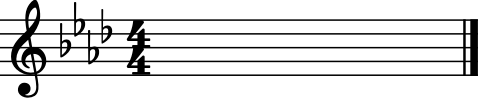

[Optional]
lecture: None
question_type: nan
question_mode: nan
key_student None is not available. set as None.


In [159]:
y.get_info()

### df_score

In [160]:
y.get_score()

-------------------- df_score --------------------
[Required]
VOICES: Index(['S', 'A', 'T', 'B'], dtype='object')
[Optional]
0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
Name: scale degree, dtype: bool


In [161]:
y.check_key()

possible_key_major: A- major
possible_key_minor: f minor, minor_leading_tone: E
The key should be f minor
The student answers None, while key detected should be f minor


# 1. 音域方面


### 個別音域 (Vocal Range)

In [162]:
vocal_range_detector = vocal_range_detection(y.VOICES, y.df_score)

In [163]:
vocal_range_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark
0,T,None,Vertical,4,Vocal range,Wrong,note B-2 lower than lower bound C3
1,B,None,Vertical,18,Vocal range,Wrong,note C2 lower than lower bound D2


### 配置 (Spacing)

In [164]:
spacing_detector = spacing_detection(y.VOICES, y.df_score)

In [165]:
spacing_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark
0,S,A,Vertical,4,Spacing,Wrong,P12 is bigger than allowable spacing P8
1,S,A,Vertical,18,Spacing,Wrong,m10 is bigger than allowable spacing P8
2,A,T,Vertical,4,Spacing,Wrong,M9 is bigger than allowable spacing P8
3,T,B,Vertical,18,Spacing,Wrong,P19 is bigger than allowable spacing P12


### 交越 (Voice Crossing)

In [166]:
voice_crossing_detector = voice_crossing_detection(y.VOICES, y.df_score)

In [167]:
voice_crossing_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark
0,A,T,Vertical,18,Voice crossing,Wrong,A: E4 is lower than T: G4
1,T,B,Vertical,4,Voice crossing,Wrong,T: B-2 is lower than B: E3


### 越位 (Overlapping)

In [168]:
overlapping_detector = overlapping_detection(y.VOICES, y.df_score)

In [169]:
overlapping_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark
0,S,A,Horizontal,"(8, 9)",Overlapping,Wrong,A: A-4 at 9 is higher than S: G4 at 8
1,T,B,Horizontal,"(8, 9)",Overlapping,Wrong,B: F3 at 9 is higher than T: E3 at 8


# 2. 旋律方面

### 單一聲部橫向進行不可有增減音程, A4,d5 除外

In [170]:
melody_interval_detector = melody_interval_detection(y.VOICES, y.df_score, y.key, y.leading_tone)

In [171]:
melody_interval_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark,Remark 2
0,S,None,Horizontal,"(16, 17)",Melody interval,Wrong,Interval Augmented Second,Interval (in simpleName) A2
1,A,None,Horizontal,"(7, 8)",Melody interval,Wrong,Interval Augmented Second,Interval (in simpleName) A2
2,A,None,Horizontal,"(8, 9)",Melody interval,Wrong,Interval Diminished Fourth,Interval (in simpleName) d4
3,A,None,Horizontal,"(12, 13)",Melody interval,Wrong,Interval Diminished Fourth,Interval (in simpleName) d4
4,T,None,Horizontal,"(7, 8)",Melody interval,Wrong,Interval Diminished Fifth,Interval (in simpleName) d5
5,T,None,Horizontal,"(8, 9)",Melody interval,Wrong,Interval Diminished Fourth,Interval (in simpleName) d4
6,B,None,Horizontal,"(1, 2)",Melody interval,Wrong,Interval Augmented Second,Interval (in simpleName) A2
7,B,None,Horizontal,"(4, 5)",Melody interval,Wrong,Interval Augmented Fifth,Interval (in simpleName) A5


### 大跳後需反向級進或小跳

In [172]:
jump_detector = melody_jump_detection(y.VOICES, y.df_score)

In [173]:
jump_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark,Remark 2
0,T,None,Horizontal,"(17, 18)",Melody_violate_big_jump,Wrong,Interval Perfect Octave,Interval (in simpleName) P8


### 導音處理：外聲部導音要到主音

In [186]:
leading_tone_resolution = leading_tone_resolution_detection(y.VOICES, y.df_score, y.key, y.leading_tone)

<music21.note.Note F>
<music21.note.Note G>
<music21.interval.Interval M2>
E5
<music21.note.Note G>
<music21.note.Note B->
<music21.interval.Interval m3>
E5
<music21.note.Note B->
<music21.note.Note C>
<music21.interval.Interval M2>
E5
<music21.note.Note C>
<music21.note.Note G>
<music21.interval.Interval P5>
E5
<music21.note.Note G>
<music21.note.Note C>
<music21.interval.Interval P-5>
E5
<music21.note.Note C>
<music21.note.Note B->
<music21.interval.Interval M-2>
E5
<music21.note.Note B->
<music21.note.Note G>
<music21.interval.Interval m-3>
E5
<music21.note.Note G>
<music21.note.Note G>
<music21.interval.Interval P1>
E5
<music21.note.Note G>
<music21.note.Note C>
<music21.interval.Interval P4>
E5
<music21.note.Note C>
<music21.note.Note C>
<music21.interval.Interval P1>
E5
<music21.note.Note C>
<music21.note.Note E>
<music21.interval.Interval M3>
E5
<music21.note.Note E>
<music21.note.Note E>
<music21.interval.Interval P1>
E5
<music21.note.Note E>
<music21.note.Note F>
<music21.inte

In [187]:
leading_tone_resolution

,Voice 1,Voice 2,Place type,Place,Wrong type,Level
0,S,None,Horizontal,"(11, 12)",leading_tone_resolution,Wrong
1,S,None,Horizontal,"(17, 18)",leading_tone_resolution,Wrong
2,B,None,Horizontal,"(1, 2)",leading_tone_resolution,Wrong
3,B,None,Horizontal,"(4, 5)",leading_tone_resolution,Wrong


### 小調導音升高

In [134]:
leading_tone_minor = leading_tone_minor_detection(y.VOICES, y.df_score, y.key, y.leading_tone)

In [135]:
leading_tone_minor

,Voice 1,Voice 2,Place type,Place,Wrong type,Level
0,A,None,Vertical,6,leading_tone_error,Wrong
1,T,None,Vertical,3,leading_tone_error,Wrong


# 4. 平行與隱伏

In [136]:
parallel_and_hidden = parallel_and_hidden_detection(y.VOICES, y.df_score)

In [137]:
# 檢查結果
parallel_and_hidden

,Voice 1,Voice 2,Place type,Place,Wrong type,Level,Remark,Remark 2
0,S,A,Horizontal,"(2, 3)",Parallel,Wrong,Interval Perfect Octave,Interval (in simpleName) P8
1,S,A,Horizontal,"(5, 6)",Parallel,Wrong,Interval Perfect Fifth,Interval (in simpleName) P5
2,S,B,Horizontal,"(8, 9)",Parallel,Wrong,Interval Perfect Twelfth,Interval (in simpleName) P5
3,A,T,Horizontal,"(8, 9)",Parallel,Wrong,Interval Perfect Octave,Interval (in simpleName) P8
4,A,B,Horizontal,"(10, 11)",Parallel,Wrong,Interval Perfect Double-octave,Interval (in simpleName) P8
5,A,B,Horizontal,"(15, 16)",Parallel,Wrong,Interval Perfect Twelfth,Interval (in simpleName) P5
6,A,B,Horizontal,"(16, 17)",Parallel,Wrong,Interval Perfect Twelfth,Interval (in simpleName) P5
7,T,B,Horizontal,"(6, 7)",Parallel,Wrong,Interval Perfect Octave,Interval (in simpleName) P8
8,T,B,Horizontal,"(12, 13)",Parallel,Wrong,Interval Perfect Fifth,Interval (in simpleName) P5
9,T,B,Horizontal,"(13, 14)",Parallel,Wrong,Interval Perfect Fifth,Interval (in simpleName) P5


# 3. 和聲方面

In [138]:
harmony_error_df = vertical_harmonic_related(y.VOICES, y.df_score, y.key, y.lecture, y.leading_tone)
harmony_error_detector = harmony_error_detection(harmony_error_df, y.lecture)

In [139]:
harmony_error_df

,S,A,T,B,measure,scale degree,Roman numerals analysis,Uncorrect,Mixture unavailable,missing_third_by_chord,missing_third_by_rn,sevenths,missing_fifth_by_chord,missing_fifth_by_rn,wrong_inversion,inharmonic_notes,multiple_leading_tone,multiple_seventh,inharmonic_notes_bool,third_warning,Wrong,Warning
0,F4,C4,A-3,F3,1,NaN,i,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
1,G4,C4,G3,E3,1,NaN,V#863,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
2,B-4,B-3,F3,D-3,1,NaN,iv6,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
3,C5,C4,E-3,C3,1,NaN,v,True,True,False,None,False,True,None,True,None,None,None,False,False,True,True
4,G5,C4,B-2,E3,2,NaN,V6#42,True,True,False,None,True,False,None,True,None,None,False,False,False,True,True
5,C5,F4,F3,A-2,2,NaN,i6,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
6,B-4,E-4,G3,G2,2,NaN,bbVII#63,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
7,G4,D-4,B-3,B-2,2,NaN,iio6,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
8,G4,E4,E3,C3,3,NaN,V5#33,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True
9,C5,A-4,A-3,F3,3,NaN,i,True,True,False,None,False,False,None,True,None,None,None,False,False,True,True


In [140]:
harmony_error_detector

,Voice 1,Voice 2,Place type,Place,Wrong type,Level
0,None,None,Vertical,0,Harmony,Wrong
1,None,None,Vertical,0,Harmony,Warning
2,None,None,Vertical,1,Harmony,Wrong
3,None,None,Vertical,1,Harmony,Warning
4,None,None,Vertical,2,Harmony,Wrong
5,None,None,Vertical,2,Harmony,Warning
6,None,None,Vertical,3,Harmony,Wrong
7,None,None,Vertical,3,Harmony,Warning
8,None,None,Vertical,4,Harmony,Wrong
9,None,None,Vertical,4,Harmony,Warning


# Post processing

In [141]:
ALL_RESULT = post_processing(y.df_score, vocal_range_detector, spacing_detector, voice_crossing_detector, overlapping_detector,
                             melody_interval_detector, jump_detector, parallel_and_hidden, harmony_error_detector)

# 結果輸出

In [87]:
ALL_RESULT

result Voice 1 Voice 2    S    A    T  \
Level   Place type Place                                                    
Wrong   Vertical   0               和聲方面有問題    None    None   F4   C4  A-3   
                   1               和聲方面有問題    None    None   G4   C4   G3   
                   2               和聲方面有問題    None    None  B-4  B-3   F3   
                   3               和聲方面有問題    None    None   C5   C4  E-3   
                   4                  個別音域       T    None   G5   C4  B-2   
                   4               和聲方面有問題    None    None   G5   C4  B-2   
                   4                  音域配置       S       A   G5   C4  B-2   
                   4                  音域配置       A       T   G5   C4  B-2   
                   4                    交越       T       B   G5   C4  B-2   
                   5               和聲方面有問題    None    None   C5   F4   F3   
                   6               和聲方面有問題    None    None  B-4  E-4   G3   
                   7               和聲方面有問題    None    None   G4  D-4  B-3   
                   8               和聲方面有問題    None    None   G4   E4   E3   
                   9               和聲方面有問題    None    None   C5  A-4  A-3   
                   10              和聲方面有問題    None    None   C5   F4  A-3   
                   11              和聲方面有問題    None    None   E5   G4  B-3   
                   12              和聲方面有問題    None    None   E5   E4   G3   
                   13              和聲方面有問題    None    None   F5  A-4   C4   
                   14              和聲方面有問題    None    None  A-5  A-4   C4   
                   15              和聲方面有問題    None    None  D-5  A-4   F4   
                   16              和聲方面有問題    None    None  D-5   F4  B-3   
                   17              和聲方面有問題    None    None   E5   G4   G3   
                   18                 音域配置       T       B   G5   E4   G4   
                   18              和聲方面有問題    None    None   G5   E4   G4   
                   18                 個別音域       B    None   G5   E4   G4   
                   18                 音域配置       S       A   G5   E4   G4   
                   18                   交越       A       T   G5   E4   G4   
                   19              和聲方面有問題    None    None   F5   F4   C4   
        Horizontal (1, 2)    單聲部橫向旋律包含增減音程       B    None  NaN  NaN  NaN   
                   (2, 3)            平行一五八       S       A  NaN  NaN  NaN   
                   (4, 5)    單聲部橫向旋律包含增減音程       B    None  NaN  NaN  NaN   
                   (5, 6)            平行一五八       S       A  NaN  NaN  NaN   
                   (6, 7)            平行一五八       T       B  NaN  NaN  NaN   
                   (7, 8)    單聲部橫向旋律包含增減音程       T    None  NaN  NaN  NaN   
                   (7, 8)    單聲部橫向旋律包含增減音程       A    None  NaN  NaN  NaN   
                   (8, 9)    單聲部橫向旋律包含增減音程       T    None  NaN  NaN  NaN   
                   (8, 9)               越位       T       B  NaN  NaN  NaN   
                   (8, 9)            平行一五八       S       B  NaN  NaN  NaN   
                   (8, 9)            平行一五八       A       T  NaN  NaN  NaN   
                   (8, 9)    單聲部橫向旋律包含增減音程       A    None  NaN  NaN  NaN   
                   (8, 9)               越位       S       A  NaN  NaN  NaN   
                   (10, 11)          平行一五八       A       B  NaN  NaN  NaN   
                   (12, 13)  單聲部橫向旋律包含增減音程       A    None  NaN  NaN  NaN   
                   (12, 13)          平行一五八       T       B  NaN  NaN  NaN   
                   (13, 14)          平行一五八       T       B  NaN  NaN  NaN   
                   (14, 15)     隱伏八五度(外聲部)       S       B  NaN  NaN  NaN   
                   (15, 16)          平行一五八       A       B  NaN  NaN  NaN   
                   (16, 17)  單聲部橫向旋律包含增減音程       S    None  NaN  NaN  NaN   
                   (16, 17)          平行一五八       A       B  NaN  NaN  NaN   
                   (17, 18)       聲部大跳違反原則       T    None  NaN  NaN  NaN   
Warning Vertical   0            

In [88]:
writer = pd.ExcelWriter(file_output_path, engine='xlsxwriter')
ALL_RESULT.to_excel(writer, sheet_name='result')
harmony_error_df.to_excel(writer, sheet_name='harmony detection')
writer.save()